In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from matplotlib import pyplot as plt

In [3]:
dataset = 'dataset'

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root=dataset, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=dataset, train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

### Import Data ###

In [40]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        # there are 2 max poolings which each half the sqrt dim of x.dim
        size_of_flattened = int(64*(x_dim/((2*2)**2)))
        self.encoderLayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=size_of_flattened, out_features=256),
            nn.ReLU()
        )

        self.mu_sample_layer = nn.Linear(in_features=256, out_features=z_dim)
        self.log_var_sample_layer = nn.Linear(in_features=256, out_features=z_dim)

        
        
        # linear from z_dim to 256
        # Linear from 256 to size_of_flattened 
        # unflatten to dimensions before flatten in encoder
        # ConvTranspose2d 64 to 32
        # ConvTranspose2d 32 1
        
        
        
        # decoder part
        self.decoderLayersPt1 = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7)
        )
        self.decoderLayersPt2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encoder(self, x):
        h = self.encoderLayers(x)
        return self.mu_sample_layer(h), self.log_var_sample_layer(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        x = self.decoderLayersPt1(z)
        x = x.view(-1, 64, 7, 7)
        x = self.decoderLayersPt2(x)
        return x
    
    def forward(self, x):
        # flatten
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")
    print(torch.__version__)
    device = torch.device("cpu")

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
vae = vae.to(device)

CUDA is available!
GPU: NVIDIA GeForce GTX 1080 Ti


In [41]:
vae

VAE(
  (encoderLayers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=256, bias=True)
    (8): ReLU()
  )
  (mu_sample_layer): Linear(in_features=256, out_features=2, bias=True)
  (log_var_sample_layer): Linear(in_features=256, out_features=2, bias=True)
  (decoderLayersPt1): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3136, bias=True)
  )
  (decoderLayersPt2): Sequential(
    (0): ReLU()
    (1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2)

In [42]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    #print the shapes
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

### Encoder and Decoder ###

In [43]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [44]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [45]:
#Try running one sample through the autoencoder
sample = next(iter(test_loader))[0][0].to(device)
print(sample.unsqueeze(0).shape)
encoderResults = vae.encoder(sample.unsqueeze(0))

sampleResults = vae.sampling(encoderResults[0], encoderResults[1]).to(device)

decoderResults = vae.decoder(sampleResults).to(device)
print(decoderResults.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


In [ ]:
for epoch in range(1, 15):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 530.733203
Train Epoch: 1 [10000/60000 (17%)]	Loss: 196.250664
Train Epoch: 1 [20000/60000 (33%)]	Loss: 178.643418
Train Epoch: 1 [30000/60000 (50%)]	Loss: 162.658223
Train Epoch: 1 [40000/60000 (67%)]	Loss: 171.287012
Train Epoch: 1 [50000/60000 (83%)]	Loss: 168.223027
====> Epoch: 1 Average loss: 179.5915
====> Test set loss: 160.4965
Train Epoch: 2 [0/60000 (0%)]	Loss: 155.690098
Train Epoch: 2 [10000/60000 (17%)]	Loss: 158.580459
Train Epoch: 2 [20000/60000 (33%)]	Loss: 153.090488
Train Epoch: 2 [30000/60000 (50%)]	Loss: 157.397646
Train Epoch: 2 [40000/60000 (67%)]	Loss: 153.442256
Train Epoch: 2 [50000/60000 (83%)]	Loss: 161.889463
====> Epoch: 2 Average loss: 157.6717
====> Test set loss: 154.9192
Train Epoch: 3 [0/60000 (0%)]	Loss: 154.726123
Train Epoch: 3 [10000/60000 (17%)]	Loss: 155.689287
Train Epoch: 3 [20000/60000 (33%)]	Loss: 160.958750
Train Epoch: 3 [30000/60000 (50%)]	Loss: 156.874072
Train Epoch: 3 [40000/60000 (67%)]	Loss: 149.23

### Train ###

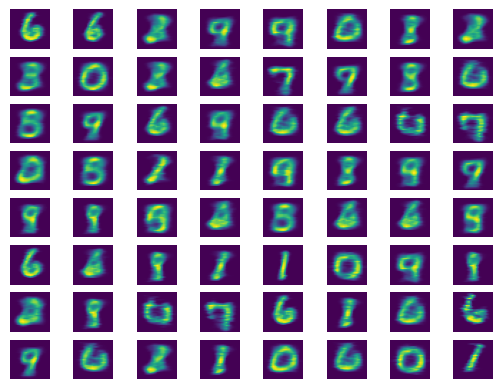

In [33]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    sample = vae.decoder(z)
    
    for (i, img) in enumerate(sample):
        plt.subplot(8, 8, i+1)
        plt.imshow(img.view(28, 28).cpu().numpy())
        plt.axis('off')
